## Forecasting with Time Series (Trends and Seasonality)

Imports:

In [41]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np

In [42]:
import opendatasets as od

Downloading Datasets:

In [43]:
dataset = 'https://www.kaggle.com/datasets/ryanholbrook/ts-course-data'

In [44]:
od.download(dataset)

Skipping, found downloaded files in ".\ts-course-data" (use force=True to force download)


In [45]:
import os

In [46]:
data_dir = './ts-course-data/'

In [47]:
os.listdir(data_dir)

['ar.csv',
 'avocados.csv',
 'book_sales.csv',
 'co2.csv',
 'elecdemand.csv',
 'flu-trends.csv',
 'reserve.csv',
 'trig.csv',
 'tunnel.csv',
 'us-retail-sales.csv']

In [48]:
dataset1 = 'https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data'


In [49]:
od.download(dataset1)

Skipping, found downloaded files in ".\store-sales-time-series-forecasting" (use force=True to force download)


In [50]:
comp_dir = './store-sales-time-series-forecasting'

In [51]:
os.listdir(comp_dir)

['holidays_events.csv',
 'oil.csv',
 'sample_submission.csv',
 'stores.csv',
 'test.csv',
 'train.csv',
 'transactions.csv']

Loading Data:

In [52]:
retail_sales = pd.read_csv(f'{data_dir}/us-retail-sales.csv',
    parse_dates=['Month'],
    index_col='Month',
).to_period('D')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(f'{comp_dir}/train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']


C:\Users\Eashwar\AppData\Local\Temp\ipykernel_1244\3769682447.py:14: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(f'{comp_dir}/train.csv',


In [53]:
retail_sales.head()

,Clothing,Appliances,FoodAndBeverage,Automobiles,GeneralMerchandise,BuildingMaterials
Month,,,,,,
1992-01-01,6938,3657,29589,26788,14996,8964
1992-02-01,7524,3490,28570,28203,16015,9023
1992-03-01,8475,3669,29682,31684,17984,10608
1992-04-01,9401,3527,30228,32547,18872,11630
1992-05-01,9558,3571,31677,32883,20037,12327


In [54]:
food_sales.head()

Month
1992-01-01    29589
1992-02-01    28570
1992-03-01    29682
1992-04-01    30228
1992-05-01    31677
Freq: D, Name: FoodAndBeverage, dtype: int64

The retail sales and food sales data contain monthly sales information.

Plotting Setup:

In [55]:
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
    grid = True

)

### Trends 

Plot Food Sales:

The plot shows the trends and fluctuations in US food and beverage sales over the specified period.

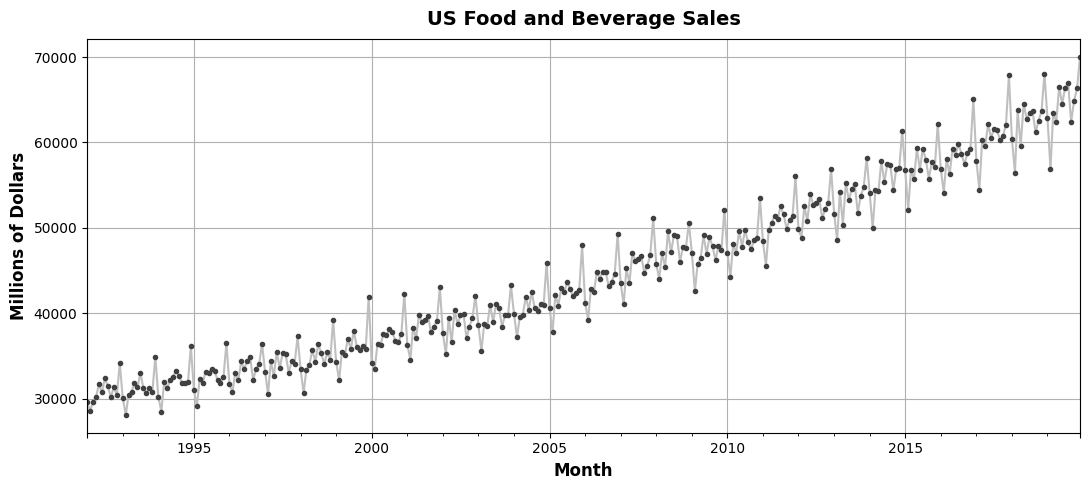

In [56]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars");

Trend Calculation and Plot:

The moving average smooths out short-term fluctuations, highlighting the overall trend in food and beverage sales.

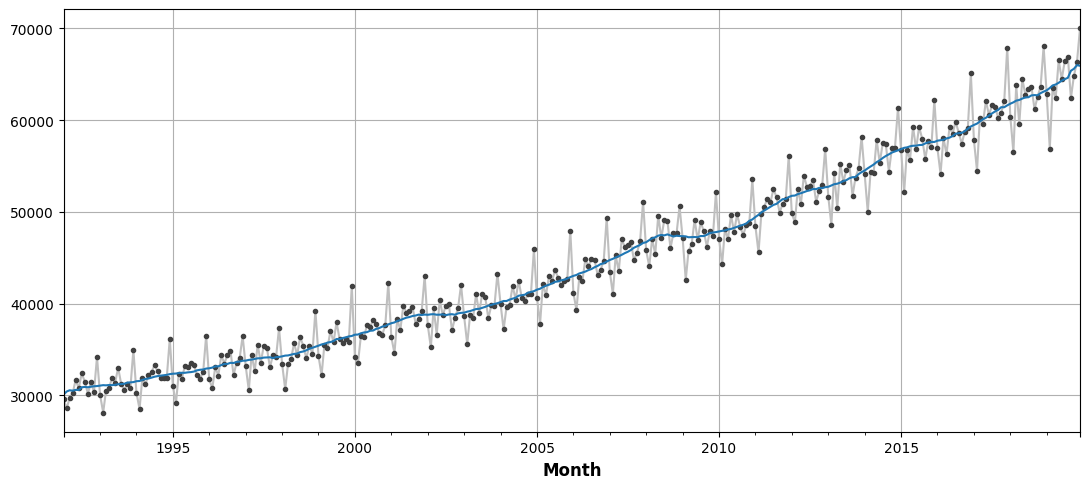

In [57]:
trend = food_sales.rolling(
    window=12,
    center=True,
    min_periods=6,
).mean()

ax = food_sales.plot(**plot_params)
ax = trend.plot(ax=ax)

ax.grid(True)
plt.show()

Average Sales Trend:

The yearly moving average reveals the long-term trend in average sales, filtering out seasonal and short-term variations.

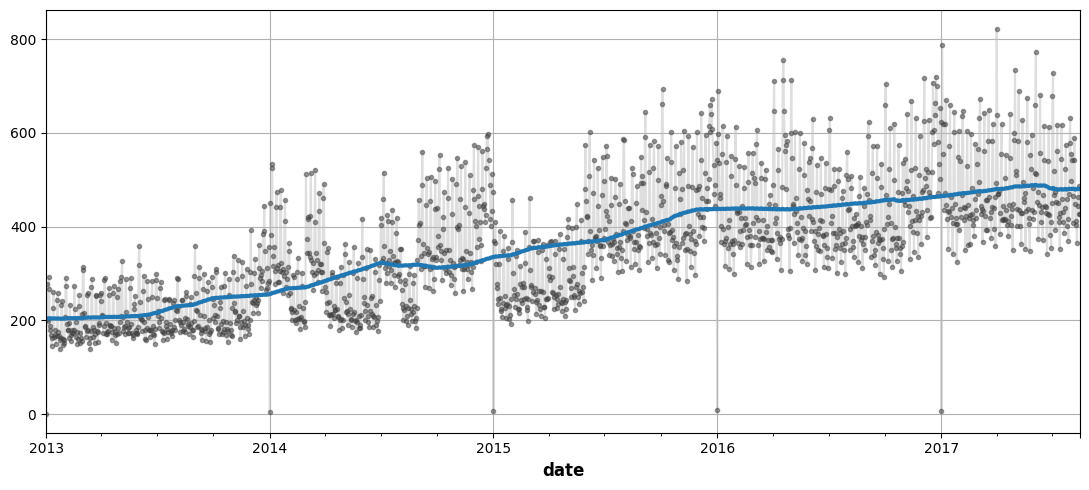

In [58]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)
ax.grid(True)
plt.show()

In [59]:
pip install statsmodels


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Trend Forecasting with Deterministic Process: 

Setting up a deterministic process for trend forecasting using a polynomial of order 3. It prepares the data for in-sample and out-of-sample predictions.

In [60]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy() 
dp =DeterministicProcess(index=y.index, order=3)

X =dp.in_sample()

X_fore =dp.out_of_sample(steps=90)

Linear Regression Model:  

The linear regression model captures the trend in average sales and provides a forecast for the next 90 days.


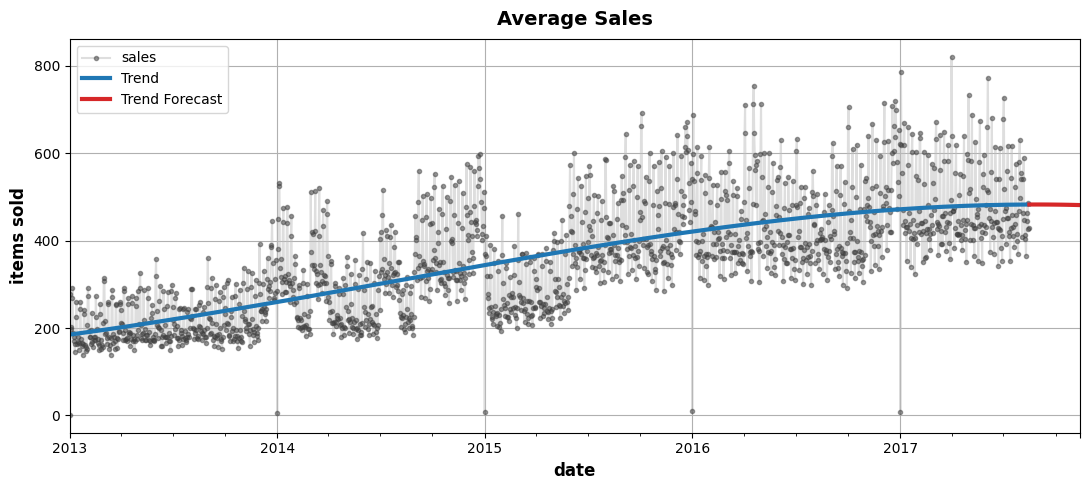

In [61]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()
ax.grid(True)
plt.savefig("my_graph.jpeg", dpi=300) 
plt.show();

Higher Order Polynomial Trend: 

The higher-order polynomial model fits the average sales data more closely, capturing more complex trends.

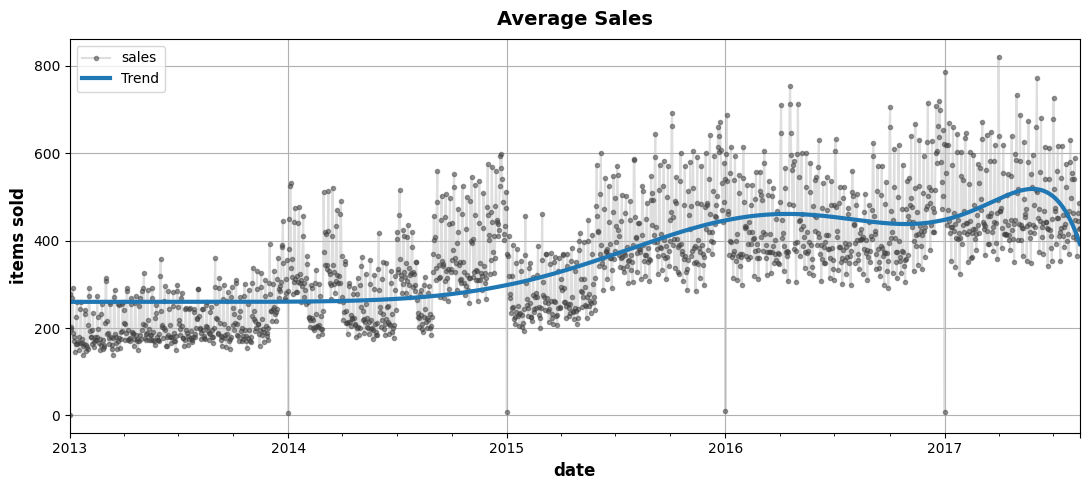

In [62]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend()
ax.grid(True)
plt.show();

Forecast with Higher Order Polynomial:  

The higher-order polynomial model provides a detailed trend forecast, showing more intricate patterns in the future sales data.

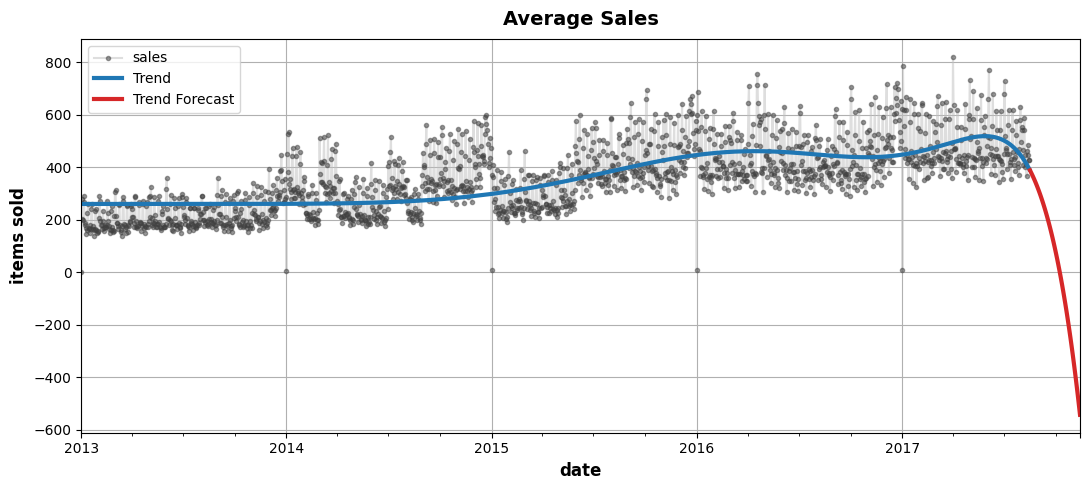

In [63]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()
ax.grid(True)
plt.show();

### Seasonality

In [64]:
holidays_events = pd.read_csv(
    f'{comp_dir}/holidays_events.csv',
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')


store_sales = pd.read_csv(
    f'{comp_dir}/train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

C:\Users\Eashwar\AppData\Local\Temp\ipykernel_1244\2924312891.py:1: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  holidays_events = pd.read_csv(
C:\Users\Eashwar\AppData\Local\Temp\ipykernel_1244\2924312891.py:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  store_sales = pd.read_csv(


In [65]:
from scipy.signal import periodogram


In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [67]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = 1
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum)
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance", labelpad=20)
    ax.set_title("Periodogram")
    return ax

Seasonal plot to discover seasonal patterns.

C:\Users\Eashwar\AppData\Local\Temp\ipykernel_1244\1565446183.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  ax = sns.lineplot(


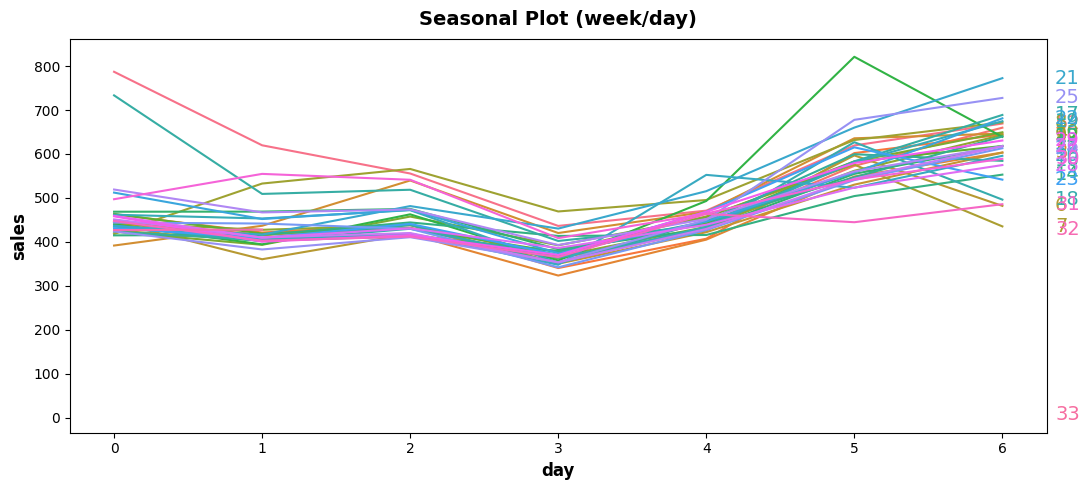

In [68]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');

In [69]:
average_sales.head()

date
2017-01-01      6.780303
2017-01-02    786.928406
2017-01-03    619.740234
2017-01-04    555.607971
2017-01-05    436.375397
Freq: D, Name: sales, dtype: float32

In [70]:
from scipy.signal import periodogram

def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta(days=365.25) / pd.Timedelta(days=1)
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()

    ax.step(frequencies, spectrum)
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y")
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

Periodogram tells you the strength of the frequencies in a time series.

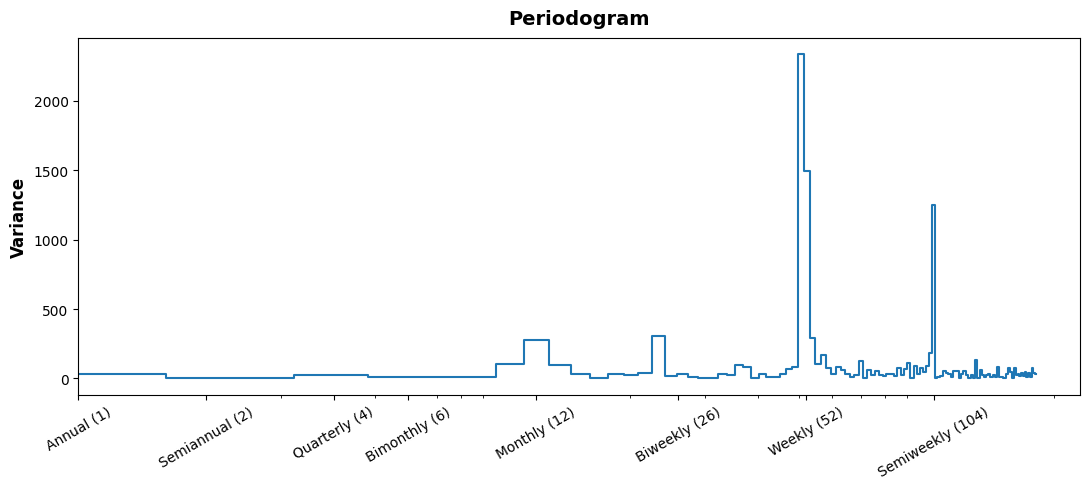

In [71]:
    plot_periodogram(average_sales)
    plt.show()

Both the seasonal plot and the periodogram indicate a pronounced weekly seasonality. Additionally, the periodogram suggests the presence of monthly and biweekly components.

Utilized DeterministicProcess and CalendarFourier to generate seasonal features.

In [72]:
from statsmodels.tsa.deterministic import CalendarFourier

y = average_sales.copy()

# YOUR CODE HERE
fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

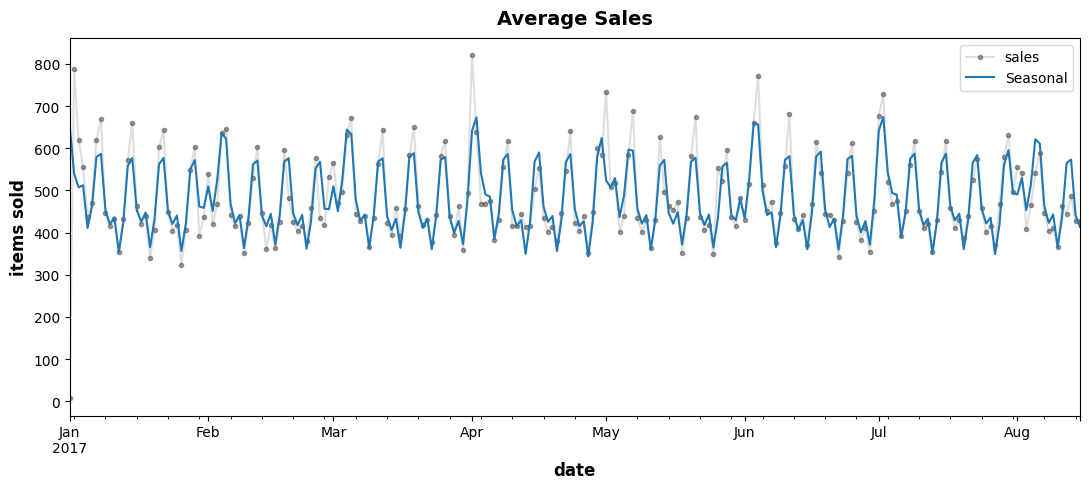

In [73]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

 Periodogram of the deseasonalized series.

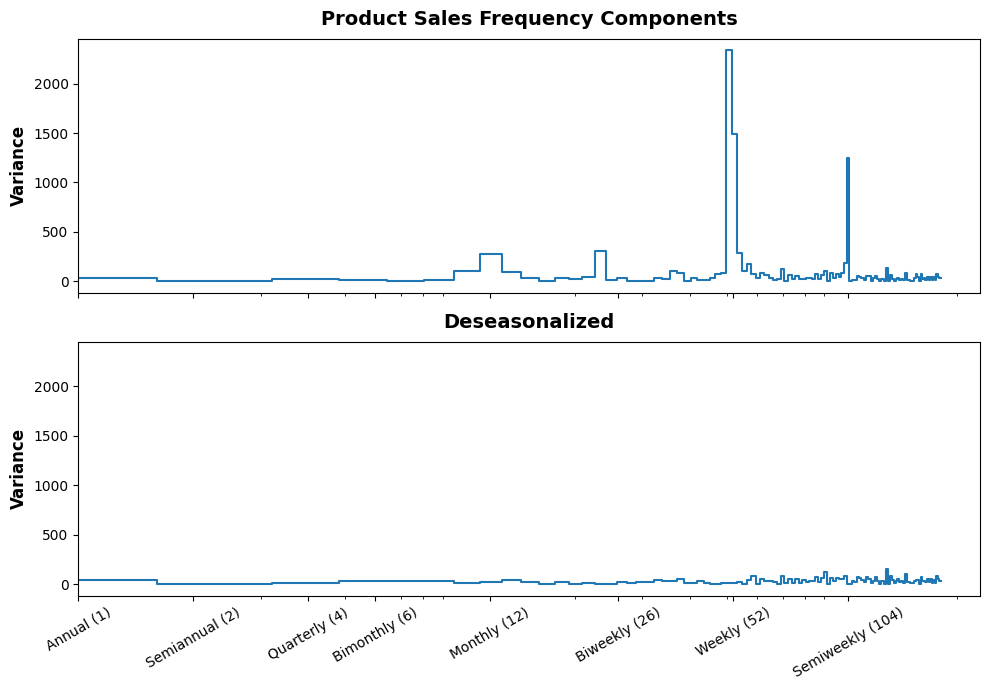

In [74]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

The periodogram for the deseasonalized series lacks any significant peaks. By comparing it to the periodogram of the original series, we can observe that our model successfully captured the seasonal variation in Average Sales.

A plot of the deseasonalized Average Sales suggests that these holidays may have some predictive power.

In [75]:
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

display(holidays)

,description
date,
2017-01-01,Primer dia del ano
2017-01-02,Traslado Primer dia del ano
2017-02-27,Carnaval
2017-02-28,Carnaval
2017-04-01,Provincializacion de Cotopaxi
2017-04-14,Viernes Santo
2017-05-01,Dia del Trabajo
2017-05-13,Dia de la Madre-1
2017-05-14,Dia de la Madre


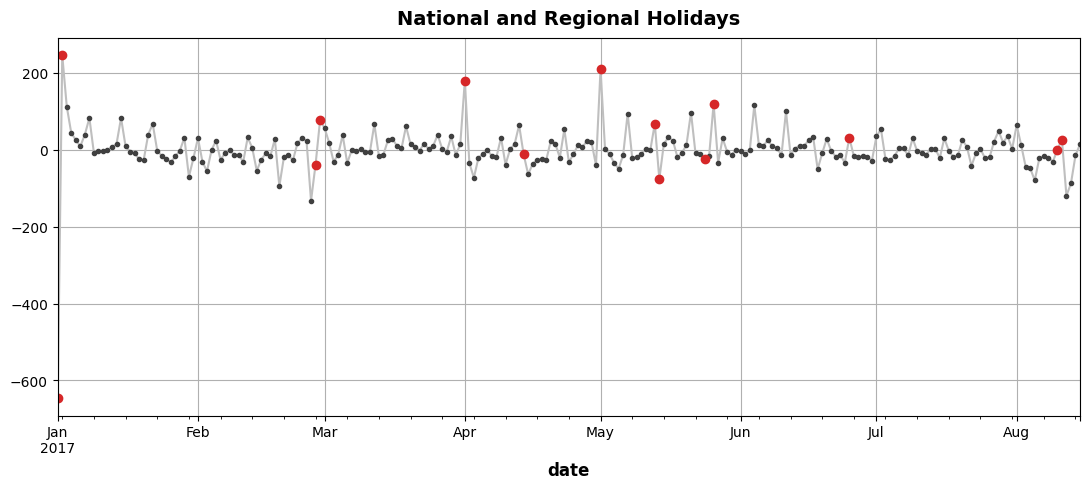

In [76]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

In [77]:
X_holidays = pd.get_dummies(holidays)

X2 = X.join(X_holidays, on='date').fillna(0.0)


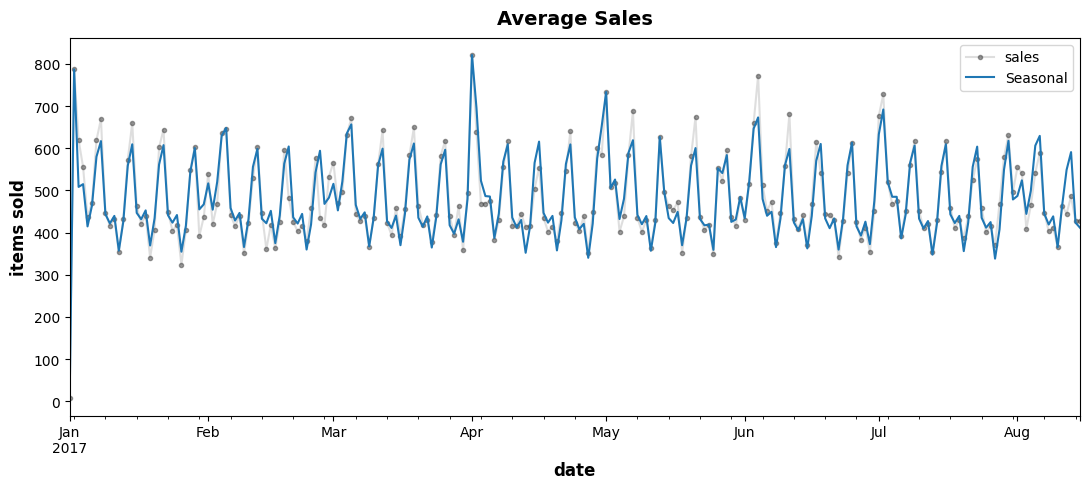

In [78]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();